# <center>  Notebook S08. Hygroscopicity Tandem DMA </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 

This notebook demostrates calculations related to the configuration where the first DMA is used as classifier. The output is conditioned in a humidifier and the resulting size distribution is measured using a second DMA in scanning mode together with a condensation particle counter (or other instrument) as detector. The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

The tandem DMA has first been described by Rader and McMurry (1986). Tandem DMA measurements are highly versatile. Park et al. (2008) reviewed an impressive list of different combinations of DMAs and detectors that have been used. Since then, additional measurement setups have been introduced in the literature. Figure 1 summarizes a typical hygroscopicity tandem DMA setup (HTMDA). Dried, charge equilibrated particles are classified in DMA 1. The flow is split to measure particle concentration with a condensation particle counter (CPC). The remaining flow is passed through a humidifier. Hygroscopic particles take up water and increase in diameter. The humidified size distribution is measured using the second DMA that is operated in scanning or stepping mode. Passage through a second bipolar charger (charge neutralizer) is optional and rarely used in TDMA experiments.  <br>

<img src="Figures/nbs8_f01.png" width="700">
<figcaption><b> Figure 1. </b> Schematic of a typical HTDMA setup. D </figcaption> 


## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, DifferentialMobilityAnalyzers, LinearAlgebra, Printf
plotlyjs();

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Block 2. Setup DMAs
For this setup two DMAs are configured. The DMAs can, but need not be identical in dimensions or flow rate. 

In [2]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/5                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 3                                            # Upper number of charges
Λ₁ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,:cylindrical)  # Specify DMA with negative polarity
Λ₂ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:+,m,:cylindrical)  # Specify DMA with negative polarity
bins,z₁,z₂ = 512, dtoz(Λ₁,500e-9),dtoz(Λ₁,30e-9) # bins, upper, lower mobility limit
δ₁ = setupDMA(Λ₁, z₁, z₂, bins);                 # Compute matrices
δ₂ = setupDMA(Λ₂, z₁, z₂, bins);                 # Compute matrices

## Block 3. Compute Monodisperse Size and Mobility Distributions
Select a single mobility diameter. Define the size-selection function T based on transfer function, charge filter, and loss function. Note that this is described in detail in Notebook S2 and S4. The mobility size distribution of the classified aerosol is estimated from the input size distribution that can be either generated from a function or from actual data. Note that this is described in detail in Notebook S4. The main difference here is the inclusion of the 𝕘 and 𝕪, which are the mobility and apparent +1 mobility diameter distribution after humidification.

It is assumed that all particles have the same growth factor. In this case,the humidification filter is simply a translation in diameter. Passage through the second DMA is described using the convolution matrix A₂ for the case with charge neutralization step and O for the case without charge neutralization step. 

In [3]:
Dm = 100.0                      # Size select 100 nm mobility diameter
gf = 2.0                        # Assumed diameter growth factor
zˢ = dtoz(Λ₁, Dm*1e-9);         # Compute corresponding electrical mobility
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp);  # DMA Transmission (Notebook 2,4)

Ax = [[1300., 60., 1.4], [2000., 200., 1.6]]   
𝕟ᶜⁿ = DMALognormalDistribution(Ax, δ₁)        # Assumed lognormal size distribution
𝕣ᶜⁿ = δ₁.𝐀*𝕟ᶜⁿ                                # CN response function. δ1.A is the forward matrix for DMA δ1

𝕟 = map(k->T(zˢ,k,Λ₁,δ₁)*𝕟ᶜⁿ,1:Λ₁.m)         # 𝕟[k] : Real size distribution of +k charges (neg. pol. DMA)
𝕘 = map(k->gf⋅(T(zˢ,k,Λ₁,δ₁)*𝕟ᶜⁿ),1:Λ₁.m)    # 𝕘[k] : Real size distributions shifted by growth factor gf 
𝕩 = map(k->(ztod(Λ₁,1,zˢ)/ztod(Λ₁,k,zˢ))⋅(T(zˢ,k,Λ₁,δ₁)*𝕟ᶜⁿ),1:Λ₁.m)      # Mobility size dist +k charges
𝕪 = map(k->(ztod(Λ₁,1,zˢ)/ztod(Λ₁,k,zˢ))⋅(gf⋅(T(zˢ,k,Λ₁,δ₁)*𝕟ᶜⁿ)),1:Λ₁.m) # Mobility size shifted by gf  

𝕟ₜ,𝕘ₜ,𝕩ₜ,𝕪ₜ = sum(𝕟),sum(𝕘),sum(𝕩),sum(𝕪); # 𝕟ₜ,𝕘ₜ,𝕩ₜ,𝕪ₜ : Reconstructed total size distribution 
𝕤𝕘,𝕤𝕘ₜ,𝕤𝕪 = map(k->δ₂.𝐀*𝕘[k], 1:3),δ₂.𝐀*𝕘ₜ,δ₂.𝐎*𝕪ₜ; # Distribution after passage through the second DMA

## Block 4. Visualize Results

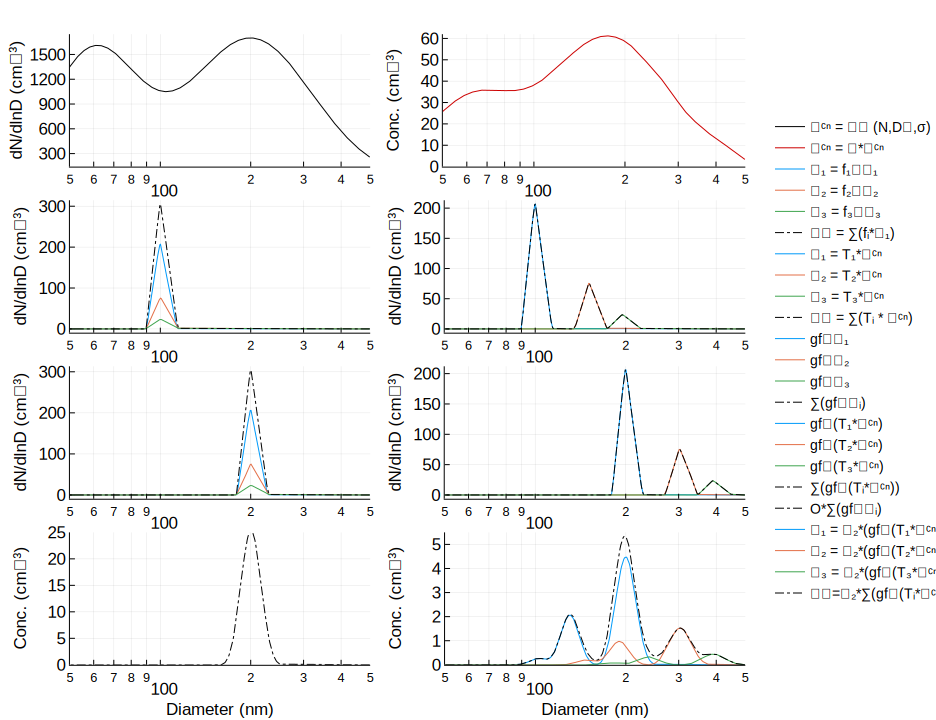

In [4]:
figure("Nimbus Sans L", 2, 6.5, 5, 8)

# Get a list of colors from the theme palette
p = Plots.get_color_palette(:auto, default(:bgcolor), 100)

p1 = plot(𝕟ᶜⁿ.Dp, 𝕟ᶜⁿ.S, xaxis = :log10, xticks = [10, 100, 1000], ylabel = "dN/dlnD (cm⁻³)", 
    label = "𝕟ᶜⁿ = 𝓛𝓝 (N,Dₘ,σ)", color = :black, left_margin = 15px)

p2 = plot(𝕣ᶜⁿ.Dp, 𝕣ᶜⁿ.N, xaxis = :log10, xticks = [10, 100, 1000], 
    label = "𝕣ᶜⁿ = 𝐀*𝕟ᶜⁿ", ylabel = "Conc. (cm⁻³)", color = RGBA(0.8,0,0), ylim = (0,62), left_margin = 15px)

p3 = plot(𝕩[1].Dp,𝕩[1].S, xaxis = :log10, xlim = (50,500), label = "𝕞₁ = f₁⋅𝕟₁", 
    ylabel = "dN/dlnD (cm⁻³)")
p3 = plot!(𝕩[2].Dp,𝕩[2].S, label = "𝕞₂ = f₂⋅𝕟₂")   
p3 = plot!(𝕩[3].Dp,𝕩[3].S, label = "𝕞₃ = f₃⋅𝕟₃")   
p3 = plot!(𝕩ₜ.Dp,𝕩ₜ.S, ls = :dashdot, color = :black, label = "𝕞ₜ = ∑(fᵢ*𝕟₁)")   

p4 = plot(𝕟[1].Dp,𝕟[1].S, xaxis = :log10, xlim = (50,500), label = "𝕟₁ = T₁*𝕟ᶜⁿ", 
    ylabel = "dN/dlnD (cm⁻³)")
p4 = plot!(𝕟[2].Dp,𝕟[2].S, label = "𝕟₂ = T₂*𝕟ᶜⁿ")   
p4 = plot!(𝕟[3].Dp,𝕟[3].S, label = "𝕟₃ = T₃*𝕟ᶜⁿ")   
p4 = plot!(𝕟ₜ.Dp,𝕟ₜ.S, ls = :dashdot, color = :black, label = "𝕟ₜ = ∑(Tᵢ * 𝕟ᶜⁿ)")   

p5 = plot(𝕪[1].Dp,𝕪[1].S, xaxis = :log10, xlim = (50,500), label = "gf⋅𝕞₁", 
    ylabel = "dN/dlnD (cm⁻³)")
p5 = plot!(𝕪[2].Dp,𝕪[2].S, label = "gf⋅𝕞₂")   
p5 = plot!(𝕪[3].Dp,𝕪[3].S, label = "gf⋅𝕞₃")   
p5 = plot!(𝕪ₜ.Dp,𝕪ₜ.S, ls = :dashdot, color = :black, label = "∑(gf⋅𝕞ᵢ)")   

p6 = plot(𝕘[1].Dp,𝕘[1].S, xaxis = :log10, xlim = (50,500), label = "gf⋅(T₁*𝕟ᶜⁿ)", 
    ylabel = "dN/dlnD (cm⁻³)")
p6 = plot!(𝕘[2].Dp,𝕘[2].S, label = "gf⋅(T₂*𝕟ᶜⁿ)")   
p6 = plot!(𝕘[3].Dp,𝕘[3].S, label = "gf⋅(T₃*𝕟ᶜⁿ)")   
p6 = plot!(𝕘ₜ.Dp,𝕘ₜ.S, ls = :dashdot, color = :black, label = "∑(gf⋅(Tᵢ*𝕟ᶜⁿ))")   

p7 = plot(𝕤𝕪.Dp,𝕤𝕪.N, color = :black, ls = :dashdot, label = "O*∑(gf⋅𝕞ᵢ)", ylim = (0,25),
    ylabel = "Conc. (cm⁻³)", xlabel = "Diameter (nm)", xscale = :log10, xlim = (50,500))

p8 = plot(𝕤𝕘[1].Dp,𝕤𝕘[1].N, xaxis = :log10, xlim = (50, 500), xlabel = "Diameter (nm)",  ylim = (0,5.5),
    ylabel = "Conc. (cm⁻³)", label = "𝕤₁ = 𝐀₂*(gf⋅(T₁*𝕟ᶜⁿ))")   
p8 = plot!(𝕤𝕘[2].Dp,𝕤𝕘[2].N,  label = "𝕤₂ = 𝐀₂*(gf⋅(T₂*𝕟ᶜⁿ))")   
p8 = plot!(𝕤𝕘[3].Dp,𝕤𝕘[3].N,  label = "𝕤₃ = 𝐀₂*(gf⋅(T₃*𝕟ᶜⁿ))")   
p8 = plot!(𝕤𝕘ₜ.Dp,𝕤𝕘ₜ.N, color = :black, ls = :dashdot, label = "𝕤ₜ=𝐀₂*∑(gf⋅(Tᵢ*𝕟ᶜⁿ))", left_margin = 31px)   

plot(p1,p2,p3,p4,p5,p6,p7,p8, layout = grid(4,2), right_margin = 30px, legend=:right, 
     top_margin = 15px,  xlim = (50, 500), fmt = :svg)

<b> Figure 2. </b> Top left: input lognormal size distribution. Top right: response function as a function of diameter. Second row left: apparent +1 mobility distribution of classified aerosol, second row right: mobility distribution. Note that these functions and plots are similar to Notebook S4, Figure 1. Third row left: apparent +1 mobility distribution after passing through the humidification system. Third row right: mobility distribution after passing through the humidification system. Bottom left: apparent +1 mobility size distribution after passing through the second DMA without charge neutralization, bottom right: apparent +1 mobility size distribution after passing through the second DMA with a second charge neutralization step. 

### Peak Concentration of Measured Mobility distribution.
Note that for unit detector efficiency, the concentration at the peak of the mobility distribution should be 2/3 of the selected number concentration after DMA1 (Rader and McMurry, 1986). This is a convenient result that allows a quick evaluation of TDMA performance by comparing peaks the concentration of CPC1 and CPC2 (Figure 1) at the peak of the distribution. This check can also be applied to test the performance of the code here.

Size selection of 100 nm particles after DMA1 yields a number concentration of 38.2 cm-3. This number can be obtained by going to the top-right panel and hovering with the mouse over the 100 nm point. In this trace, the number concentration is obtained from the convolution matrix. Size selection of 200 nm after DMA2 yields a number concentration of 25.4 cm-3. This number can be obtained  by going to the bottom-left panel and hovering with the mouse over the 200 nm point. The ratio equals the predicted value 0.67. Below the ratio is computed in a slightly different manner. The number concentration after size selection is obtained as in Notebook S2,S4 using the single size selection transmission function.  

In [5]:
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp)
Nz = (zˢ,Λ,δ) -> Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m)
𝕟 = Nz(zˢ,Λ₁,δ₁)
@sprintf("N after DMA1 %.1f cm-3, Max N after DMA2 %.1f cm-3, Ratio: %.2f", 
    maximum(𝕤𝕪.N), sum(𝕟.N), maximum(𝕤𝕪.N)./sum(𝕟.N))

"N after DMA1 25.4 cm-3, Max N after DMA2 38.2 cm-3, Ratio: 0.67"

## Block 5. Generalized Analysis
Below an abbreviated version of Figure 2 is produced, using a set of generalize transmission functions. This is also to illustrate that the expressions can be formulated in different ways, depending on the preference of the user. Note the inclusion of Λ,δ in the function call. This is done to cleanly differentiate passage trough DMAs 1 and 2. 

In [6]:
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp) # Transfer model through DMA
Nkz = (zˢ,k,Λ,δ) -> gf⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ)  # Mobility size distribution for particles with charge k
Nz = (zˢ,Λ,δ) -> Σ(k->gf⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ),Λ₁.m) # Total mobility size distribution for all charges 1..n
Nkm = (zˢ,k,Λ,δ) -> ((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(gf⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))) # App. +1 Mobility dist k charges
Nm =(zˢ,Λ,δ) -> Σ(k->((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(gf⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))),Λ₁.m); # Total all charges

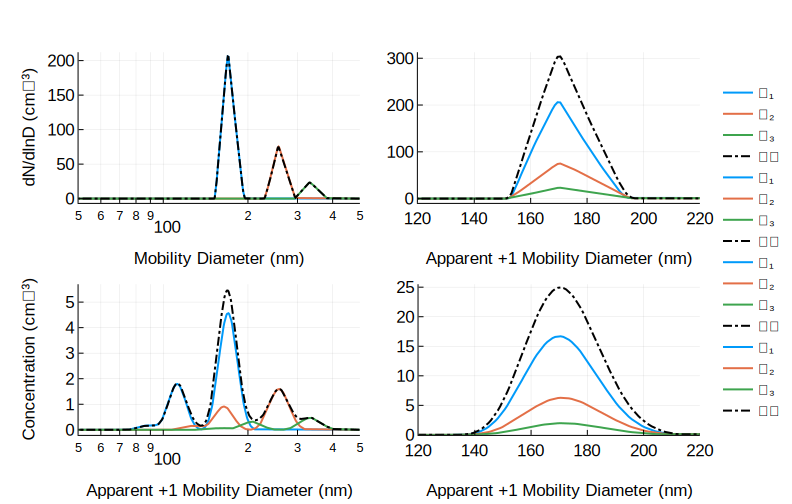

In [7]:
# Setup the special case
Dm = 100                 # Dry size 100 nm
zˢ = dtoz(Λ₁, Dm*1e-9);  # Compute corresponding electrical mobility
n = 3      # Charges 1..3
gf = 1.7   # Growth factor

figure("Nimbus Sans L", 2, 5.5, 3.5, 8)

# Panel 1: Assumed diameter
𝕩 = map(k -> Nkz(zˢ,k,Λ₁,δ₁), 1:3)
𝕪 = Nz(zˢ,Λ₁,δ₁)
p1 = plot(𝕩[1].Dp, 𝕩[1].S, label = "ℕ₁<sup>δ₁</sup>", xaxis = :log10, xlim = (50,500),
         xlabel = "Mobility Diameter (nm)")
p1 = plot!(𝕩[2].Dp, 𝕩[2].S, label = "ℕ₂<sup>δ₁</sup>")
p1 = plot!(𝕩[3].Dp, 𝕩[3].S, label = "ℕ₃<sup>δ₁</sup>")
p1 = plot!(𝕪.Dp, 𝕪.S, color = :black, label = "𝕟ₜ<sup>δ₁</sup>", ls = :dashdot, lw = 1.25, 
    ylabel = "dN/dlnD (cm⁻³)", left_margin = 30px)

# Panel 2: Mobility diameter
𝕩 = map(k -> Nkm(zˢ,k,Λ₁,δ₁), 1:3)
𝕪 = Nm(zˢ,Λ₁,δ₁)
p2 = plot(𝕩[1].Dp, 𝕩[1].S, xlim = (120, 220), label = "𝕄₁<sup>δ₁</sup>", 
         xlabel = "Apparent +1 Mobility Diameter (nm)")
p2 = plot!(𝕩[2].Dp, 𝕩[2].S, label = "𝕄₂<sup>δ₁</sup>")
p2 = plot!(𝕩[3].Dp, 𝕩[3].S, label = "𝕄₃<sup>δ₁</sup>")
p2 = plot!(𝕪.Dp, 𝕪.S, color = :black, lw = 1.25, ls = :dashdot, label = "𝕞ₜ<sup>δ₁</sup>")

# Panel 3: Passage through DMA
𝕩 = map(k -> δ₂.𝐀*Nkz(zˢ,k,Λ₁,δ₁), 1:3)
𝕪 = δ₂.𝐀*Nz(zˢ,Λ₁,δ₁)
p3 = plot(𝕩[1].Dp, 𝕩[1].N, label = "ℕ₁<sup>δ₂</sup>")
p3 = plot!(𝕩[2].Dp, 𝕩[2].N, label = "ℕ₂<sup>δ₂</sup>")
p3 = plot!(𝕩[3].Dp, 𝕩[3].N, label = "ℕ₃<sup>δ₂</sup>")
p3 = plot!(𝕪.Dp, 𝕪.N, xaxis = :log10,  ylim = (-0.2,5.7), xlim = (50,500), color = :black, ls = :dashdot,
            left_margin = 34px, lw = 1.25, xlabel = "Apparent +1 Mobility Diameter (nm)", 
            label = "𝕟ₜ<sup>δ₂</sup>", ylabel = "Concentration (cm⁻³)")

# Panel 4: Mobility diameter + passage through DMA
𝕩 = map(k -> δ₂.𝐎*Nkm(zˢ,k,Λ₁,δ₁), 1:3)
𝕪 = δ₂.𝐎*Nm(zˢ,Λ₁,δ₁)
p4 = plot(𝕩[1].Dp, 𝕩[1].N, label = "𝕄₁<sup>δ₂</sup>")
p4 = plot!(𝕩[2].Dp, 𝕩[2].N, label = "𝕄₂<sup>δ₂</sup>")
p4 = plot!(𝕩[3].Dp, 𝕩[3].N, label = "𝕄₃<sup>δ₂</sup>")
p4 = plot!(𝕪.Dp, 𝕪.N, xlim = (120,220), xlabel = "Apparent +1 Mobility Diameter (nm)", lw = 1.25, 
          ls = :dashdot, color = :black, left_margin = 18px, ylim = (0,25.5), label = "𝕞ₜ<sup>δ₂</sup>")

plot(p1,p2,p3,p4, layout = grid(2,2), legend=:right, top_margin = 35px, right_margin = 20px, lw = 2,
     bottom_margin = 20px, fmt = :svg)

<b> Figure 3. </b> Same as Figure 2, but computed with the four expressions described above. Blue, orange, and green solid lines denote +1, +2, and +3 charges. The dashdotted lines represent the sum of the three individual charge contributions. Top left: Mobility size distribution of size selected particles after passing through the humidification system modeled with expression ∑[gf$⋅$(Tᵢ$*$𝕟ᶜⁿ)]. Top right: The same distribution mapped onto the mobility grid modeled with expression ∑[(dᵢ/d₁)$⋅$(gf$⋅$(Tᵢ$*$𝕟ᶜⁿ)))]. Bottom left: Apparent +1 mobility size distribution passed through a neutralizer followed by transit through DMA2 modeled with expression 𝐀₂$*$(∑[gf$⋅$(Tᵢ$*$𝕟ᶜⁿ)]). Bottom right: Apparent +1 mobility ize distribution after transit through DMA2 without charge neutralization and modeled with expression 𝐎₂$*$(∑[(dᵢ$/$d₁)$⋅$(gf$⋅$(Tᵢ$*$𝕟ᶜⁿ)))]).

### Growth Factor Distributions
The above assumes that the particles have a single growth factor. For ambient data, growth factor is often distributed. The mobility response function after DMA2 without a second charge neutralization is rewritten as a function of gf. Also the convolution matrix O is folded into the function. Then let Pᵢ denote the probability that a particle has growth factor gfᵢ. A parametric distribution can be written as an array of P and an array of gf, subject to the constraint that sum(P) = 1. In this case the response function is computed as 
```julia
y = sum(map(i->(P[i]*Nmdist(zˢ, gf[i])), 1:length(P)))
```

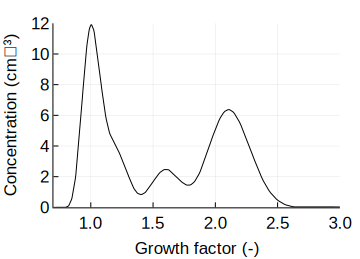

In [8]:
figure("Nimbus Sans L", 2, 2.5, 1.8, 8)

# Setup the special case
Dm = 100                 # Dry size 100 nm
zˢ = dtoz(Λ₁, Dm*1e-9);  # Compute corresponding electrical mobility
n = 3                    # Charges 1..3

Nmdist = (zˢ,gf) -> δ₂.𝐎*Σ(k->((ztod(Λ₁,1,zˢ)/ztod(Λ₁,k,zˢ))⋅(gf⋅(𝕥=T(zˢ,k,Λ₁,δ₁)*𝕟ᶜⁿ))),Λ₁.m)
P = [0.5,0.15, 0.10, 0.25]   # Probability of growth factor (4 populations)
gf = [1.0, 1.2, 1.6, 2.1]    # Values of growth factor
y = sum(map(i->(P[i]*Nmdist(zˢ, gf[i])), 1:length(P)))  # The growth factor distribution

plot(y.Dp/Dm, y.N, xlabel = "Growth factor (-)", ylabel = "Concentration (cm⁻³)", color = :black, 
     legend = :none, left_margin = 10px, ylim = (0,12), xlim = (0.7, 3), right_margin = 20px, fmt = :svg)

<b> Figure 4. </b> Predicted growth factor distribution for the four component model comprising gf = 1, 1.2, 1.6, and 2.1. The curve gives the response function normalized by the assumed dry diameter (100 nm) as predicted by the forward model O₂$*$(∑[(dᵢ$/$d₁)$⋅$(gf$⋅$(T₁$*$𝕟ᶜⁿ)))]). 

## Summary and Conclusions
Distributions arising in TDMA applications can be modeled using a combination of size distribution arithmetic (Notebook S3). The five key expressions are 

```julia
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp) # Transfer model through DMA
Nkz = (zˢ,k,Λ,δ) -> gf⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ)  # Size distribution for particles with charge k
Nz = (zˢ,Λ,δ) -> Σ(k->gf⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ),Λ₁.n) # Total size distribution for all charges 1..n
Nkm = (zˢ,k,Λ,δ) -> ((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(gf⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))) # App. Mobility dist. k charges
Nm =(zˢ,Λ,δ) -> Σ(k->((ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(gf⋅(𝕥=T(zˢ,k,Λ,δ)*𝕟ᶜⁿ))),Λ₁.n); # Total all charges
```
where T describes the transfer through the DMA, Nkz describes the mobility size distribution for mobility selection Zs and k charges, Nz is the mobility size distribution for all charges, Nkm is the apparent +1 mobility distribution for mobility selection Zs and k charges, and Nm is the mobility distribution for all charges. The response function after DMA is obtained using the above expression and the convolution matrices (Notebook S2). The approach is easily adapted to handle growth factor distributions. In the case where no charge neutralization occurs before passage through DMA2, the gf distribution is modeled as

```julia
Nmdist = (zˢ,gf) -> δ₂.𝐎*Σ(k->((ztod(Λ₁,1,zˢ)/ztod(Λ₁,k,zˢ))⋅(gf⋅(𝕥=T(zˢ,k,Λ₁,δ₁)*𝕟ᶜⁿ))),Λ₁.n)
y = sum(map(i->(P[i]*Nmdist(zˢ, gf[i])), 1:length(P)))  # The growth factor distribution
```
where P is the probability that particle has growth factor gf.

## References
Rader, D.J. and P.H. McMurry (1986) Application of the tandem differential mobility analyzer to studies of droplet growth or evaporation,Journal of Aerosol Science, 17(5), 771-787,DOI:10.1016/0021-8502(86)90031-5.

Park, D. Dutcher, M. Emery, J. Pagels, H. Sakurai, J. Scheckman, S. Qian, M. R. Stolzenburg, X. Wang, J. Yang & P. H. McMurry (2008) Tandem Measurements of Aerosol Properties—A Review of Mobility Techniques with Extensions, Aerosol Science and Technology, 42:10, 801-816, DOI:10.1080/02786820802339561.